# Octopus Optokinetic Response Analysis Demo

* Rose Al-Saadi (ralsaadi@uoregon.edu)
* Jacob Lambert (jlambert@cs.uoregon.edu)
* https://gitlab.com/lamb/octopus-okr-demo
* Based on Juypter notebook by Elliott Abe (eab@uoregon.edu)

In this notebook, we demonstrate the steps carried out to visualize the data collected in the *Octopus Optokinetic Response Analysis Study*. Vision is a critical sense for cephalopods, but little is known about the visual acuity or visual information processing of octopuses. One way to gauge the visual acuity of an organism is to measure their *optokinetic reflexes* (OKR). In this study, we attempt to answer the following question: **Do *Octopus bimaculoides* exhibit optokinetic reflexes?**

<center>
<figure>
    <img src='images/octopus_bimaculatus.jpeg'  width='600'>
    <figcaption>
        <a href="https://en.wikipedia.org/wiki/Octopus_bimaculatus"><i>Octopus bimaculatus</i></a>
        <a href="https://www.joelsartore.com/ani041-00291/"> [source]</a>
    </figcaption>
</figure>
</center>

### Study Overview

The study consists of three stages: 
1. data collection using a physical OKR rig and trails with individual *Octopus Bimaculatus* specimens. 
2. data processing using <a href="http://www.mackenziemathislab.org/deeplabcut">DeepLabCut</a> and Recurrent Neural Networks
3. data visualization using Pandas and Matplotlib (this notebook)

#### The OKR Rig
The OKR Rig is a physical device, with a cylindrical water tank on the inside, and rotating screen or sheet on the outside. The rotating sheet has markings on it. By rotating the sheet outside the tank, with an octopus specimen in the tank, we can assess the octopus's visual acuity by observing how it responds to the rotation of the marking. In this study, the rotating screen is rotated in one direction for a set amount of time, and then rotated in the opposite direction. These changes in rotation are captured in the Boris data files.
<center>
<figure>
    <img src='images/octo-okr-flow.png'>
    <figcaption>Stages of Octopus OKR Workflow</figcaption>
</figure>
</center>


### The Data
Our original data consists of:
- Raw video footage of the octopus individuals during the OKR trials (.MOV files)
- Data from <a href="https://www.boris.unito.it/">Boris</a> reporting the rotation of the physical OKR device (.csv files)
- Data generated by DeepLabCut after annotating video data and applying DNN filters to track object movement (.h5 files)


#### DeepLabCut GUI Process
After recording vidoes of the octopus specimen during operation of the OKR rig, the videos are imported into DeepLabCut. Using the DeepLabCut (DLC) GUI, features of the octopus organism are manually labeled in individual frames of the video. Then, using built-in Recurrent Neural Network algorithms, DLC applies feature tracking to automatically determine the location of the relevant features in unlabeled frames. In the case of our octopus organism, we label the head and eyes of the octopus. 
<center>
<figure>
    <img src='images/dlc_labels.png'>
    <figcaption>DLC GUI interface</figcaption>
</figure>
</center>

After labeling several frames of a video, DLC attempts to track the points of interest on an organism throughout the entire video, similar to this example.

<center>
<figure>
    <a href="http://www.mackenziemathislab.org/deeplabcut"><img src='images/dlc_example.gif'></a>
    <figcaption>Example tracking after labeling</figcaption>
</figure>
</center>


### Load Packages

In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob 

pd.options.mode.chained_assignment = None # prevents over-eager warnings

trial = 0 # set to 0 or 1 to change trial visualized

### Import Borris Rotation Data
We use the <a href="https://www.boris.unito.it/">Boris Software Package</a> to track event-logging data during the operation of the OKR rig. Specfically, Boris logs an even each time the OKR device changes rotation direction, and stores this data in a csv file.

In [231]:
base_path = './data/'

csv_filenames = glob(base_path + '*.MOV.csv')


boris_data = pd.read_csv(csv_filenames[trial], header=15)
boris_data['Time']

0      2.902
1     36.150
2     36.151
3     65.609
4     65.610
5     95.434
6     95.435
7    128.376
Name: Time, dtype: float64

Here we subset the data to only capture changes in rotations (instead of starts and stops).

In [255]:
cw = boris_data[boris_data['Behavior'] == 1]['Time']
cw.index = range(len(cw))
cw

0     2.902
1    36.150
2    65.610
3    95.434
Name: Time, dtype: float64

### Import DeepLabCut ResNet Data
Data generated by the DLC ResNet algorithms (after manually labeling using the DLC GUI) is stored as .h5 files. These files are imported below and processed in the following sections. The files contain the following data:

* For each labeled body part
   * For each frame in the video
       * x coordinate
       * y coordinate
       * likelihood (or confidence)


In [230]:
base_path = './data/'
dlc_filenames = glob(base_path + '*filtered.h5')

['./data/0429_1_0.16_10DLC_resnet50_OctoGratingsApr23shuffle1_515000_filtered.h5',
 './data/0429_1_0.16_45DLC_resnet50_OctoGratingsApr23shuffle1_515000_filtered.h5']

In [232]:
dlc = pd.read_hdf(dlc_filenames[trial])
dlc = dlc['DLC_resnet50_OctoGratingsApr23shuffle1_515000'] # flatten scorer name
dlc.head(3)
len(dlc)

4508

### Filter DLC Data Based on Threshold Value
Values under the specified threshold were not correctly captured by the camera. These values can be safely treated as noise and ommitted. Below we have the original clamping code, and an updated version that uses the original MultiIndex data.

#### Old Threshold/Clamping Code

In [218]:
#pts.columns = [' '.join(col[:][1:3]).strip() for col in pts.columns.values]
#pts = pts.rename(columns={pts.columns[n]: pts.columns[n].replace(' ', '_') for n in range(len(pts.columns))})
#pt_loc_names = pts.columns.values

#thresh=.95
#likeli_loop_count = 0
#df = pd.DataFrame()
#for pt_num in range(0, len(pts.keys())):
#    current_pt_loc = pts.keys()[pt_num]
    #print (current_pt_loc)
#    if 'likelihood' in current_pt_loc:
#        # find the associated x and y points of the selected likelihood
#        # assumes order is x, y, likelihood, will cause problems if isn't true of data...
#        assoc_x_pos = pts.keys()[pt_num - 2]
#        assoc_x_pt = pts[assoc_x_pos]
#        assoc_y_pos = pts.keys()[pt_num - 1]
#        assoc_y_pt = pts[assoc_y_pos]

        # select only the likelihood data for this point
#        likeli_pt = pts[current_pt_loc]

        # set x/y coords to NaN where the likelihood is below threshold value
#        assoc_x_pt[likeli_pt < thresh] = np.nan
#        assoc_y_pt[likeli_pt < thresh] = np.nan
#        df[assoc_x_pos] = assoc_x_pt
#        df[assoc_y_pos] = assoc_y_pt
#        df[current_pt_loc] = likeli_pt

#### Updated Threshold/Clamping Code (Maintaining MultiIndex Data Structure)

In [219]:
thresh=.95
for bodypart in list(dlc.columns.levels[0]):
    dlc.loc[:, (bodypart,'x')][dlc.loc[:, (bodypart,'likelihood')]  < thresh] = np.nan
    dlc.loc[:, (bodypart,'y')][dlc.loc[:, (bodypart,'likelihood')]  < thresh] = np.nan

### Calculate and Plot Head Angle Over Time

In [220]:
x_eye = dlc['pupil_right']['x'] + (dlc['pupil_left']['x'] - dlc['pupil_right']['x']) / 2
y_eye = dlc['pupil_right']['y'] + (dlc['pupil_left']['y'] - dlc['pupil_right']['y']) / 2

head_line = np.array([[dlc['mantle']['x'], dlc['mantle']['y']], [x_eye, y_eye]])

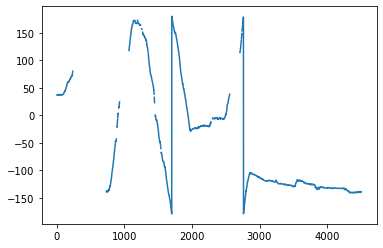

In [221]:
headang = (np.arctan2((head_line[0,1] - head_line[1,1]),
                      (head_line[0,0] - head_line[1,0])) * 180 ) / np.pi
plt.plot(headang);

### Plotting and Animating the Location of Body Parts Over Time

Here we reorganize the data to get the x and y values for each body part.

In [222]:
# old calculation using flattened data structre to isolate x and y values for all bodyparts
#x_points = pts.iloc[:10,0::3]#.iloc[:,[2,5]]
#y_points = pts.iloc[:10,1::3]#.iloc[:,[2,5]]

# MultiIndex calculation to isolate x and y values for all bodyparts
x_points = dlc.xs('x', level=1, axis=1)
y_points = dlc.xs('y', level=1, axis=1)
keys = x_points.keys()

#### Static Plot
Below is a static plot of the octopus body part locations over throughout the trial. Although this plot shows the summary of the movements of the octopus during the trial, it does not give much insight into the visual acuity of the octopus with respect to the rotating sheet.

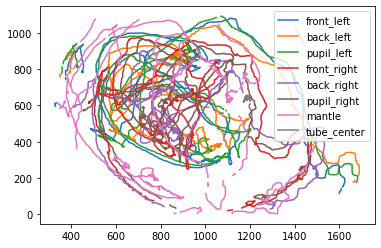

In [260]:
plt.plot(x_points,y_points)
plt.legend(keys);

#### Animated Plots
We create two animated plots (one for each rotation direction). Regenerating these animation can be slow (~60s).

First, we calcualte the framerate using the Boris data and the number of frames (rows) in our DLC data structure.

In [246]:
fps = int ((len(x_points) / boris_data['Time'][7]))
fps

35

Now, we can create an animated plot of the first rotation, roughly time 0:36 or frames 0:1260.

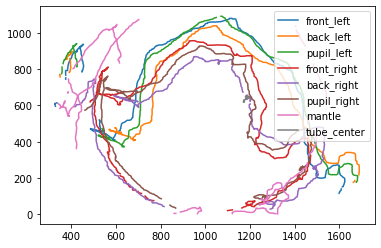

In [250]:
import matplotlib.animation as animation

# remove first few points (no activity)
start = 100
# calculate frame where rotation switches
end = int (cw[1] * fps)

x_rot = x_points[start:end] 
y_rot = y_points[start:end]

fig, ax = plt.subplots();
lines = ax.plot(x_rot,y_rot);

def update(i):
    for lnum, line in enumerate(lines):
        line.set_data(x_rot[keys[lnum]][:i], y_rot[keys[lnum]][:i])
    return lines

plt.legend(keys);
ani = animation.FuncAnimation(fig, update, len(x_rot), interval=50, blit=True);
ani.save('images/animated_rot1.gif');

In this animated plot, we can cleary see the counter-clockwise movement patterns (automatically tracked using DLC), and their correspondance to the counter-clockwise rotation of the sheet outside the tank.

<center>
<figure>
    <img src='images/animated_rot1.gif'>
    <figcaption>Animated Lines of Octopus Movement (rotation 1)</figcaption>
</figure>
</center>

Now, we can create an animated plot of the second rotation in the opposite direction, roughly time 36:66

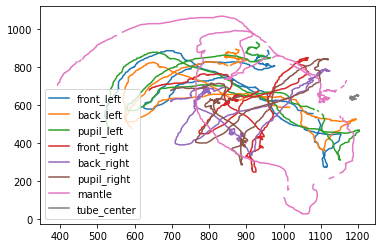

In [257]:
start = int (cw[1] * fps)
end = int (cw[2] * fps)

x_rot = x_points[start:end] 
y_rot = y_points[start:end]

fig, ax = plt.subplots();
lines = ax.plot(x_rot,y_rot);

def update(i):
    for lnum, line in enumerate(lines):
        line.set_data(x_rot[keys[lnum]][:i], y_rot[keys[lnum]][:i])
    return lines

plt.legend(keys);
ani = animation.FuncAnimation(fig, update, len(x_rot), interval=50, blit=True);
ani.save('images/animated_rot2.gif');

In this second animated plot, the rotation of the sheet and markings is now clockwise. Although less clear than the first example above, we can still see how the octopus is responding to the clockwise rotation.

<center>
<figure>
    <img src='images/animated_rot2.gif'>
    <figcaption>Animated Lines of Octopus Movement (rotation 2)</figcaption>
</figure>
</center>

### Head and Pupil Angles Compared

In [209]:
line_head = np.array([[dlc['pupil_left']['x'],dlc['pupil_left']['y']],
                      [dlc['pupil_right']['x'],dlc['pupil_right']['y']]])


line_head2 = np.array([[dlc['front_left']['x'],dlc['front_left']['y']],
                       [dlc['front_right']['x'],dlc['front_right']['y']]])

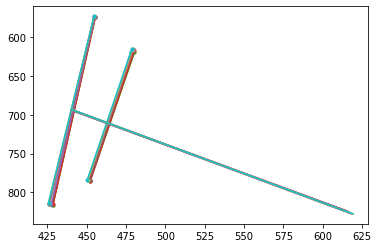

In [210]:
dt = 10
plt.plot(line_head[:,0,:dt],line_head[:,1,:dt], '.-')
plt.plot(line_head2[:,0,:dt],line_head2[:,1,:dt], '.-')

plt.plot(head_line[:,0,:dt], head_line[:,1,:dt])
plt.gca().invert_yaxis();

### Plots for Likelihood of Each Bodypart

We see below that most bodyparts had a high likelyhood outside the 400-1000 range except the *mantle* which, had a very incosistent likelyhood for much of the data.

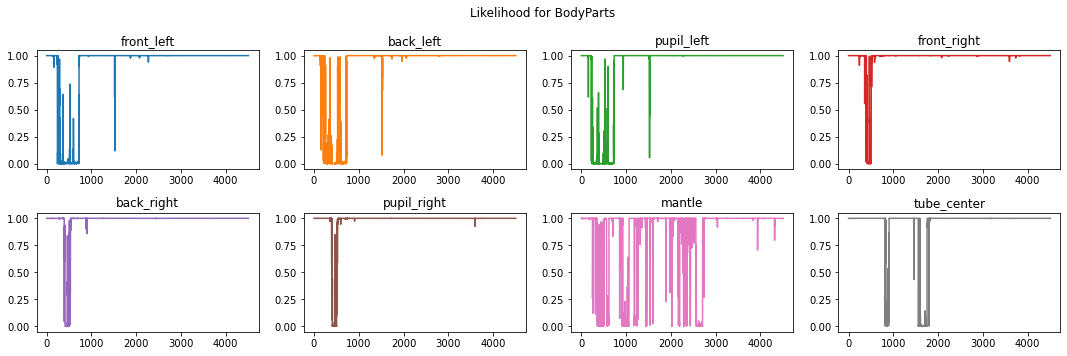

In [211]:
likelihood_points = dlc.xs('likelihood', level=1, axis=1)

# get colors
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)
fig.suptitle('Likelihood for BodyParts')
for index in range(0, 8):
    plt.subplot(2, 4, index+1)
    plt.plot(likelihood_points[keys[index]], colors[index])
    plt.title(keys[index])

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=100, hspace=None)
plt.tight_layout();